# Automl 하기 전에 전처리

In [ ]:
# @title
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# @title
!pip install iterative-stratification
!pip install optuna
!pip install --upgrade category_encoders
!pip install catboost

In [ ]:
# @title
!pip install flaml

In [ ]:
# @title
import sys
import numpy as np
import pandas as pd
import os


# ignore warning
import warnings
warnings.filterwarnings('ignore')

# ML
from sklearn.ensemble import RandomForestClassifier  # Bagging
from xgboost.sklearn import XGBClassifier            # GBM
from sklearn.linear_model import LogisticRegression  # LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA


# for checking multi-collinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# KFold(CV), partial : for optuna
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE


# Import sklearn classes for model selection, cross validation, and performance evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# Import libraries for gradient boosting
import xgboost as xgb
import lightgbm as lgb
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from flaml import AutoML

# Hide convergence warning for now
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [ ]:
# @title
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ICR/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ICR/test.csv')
greeks = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ICR/greeks.csv')

pd.set_option('display.max_columns', None)

In [ ]:
# @title
train['EJ'] = train['EJ'].replace({'A': 0, 'B': 1})
test['EJ']  = test['EJ'].replace({'A': 0, 'B': 1})
target_col = 'Class'

X_train = train.drop([f'{target_col}', 'Id'],axis=1).reset_index(drop=True)
y_train = train[f'{target_col}'].reset_index(drop=True)

X_test = test.drop(['Id'],axis=1).reset_index(drop=True)

# 결측치 KNNImputer 사용
imp = KNNImputer()
X_train_1=imp.fit_transform(X_train)
X_test_1 = imp.transform(X_test)

tmp1 = pd.DataFrame(columns=X_train.columns, data = X_train_1)
X_train = pd.concat([tmp1], axis=1)

tmp2 = pd.DataFrame(columns=X_test.columns, data = X_test_1)
X_test = pd.concat([tmp2], axis=1)


# 'EJ'만 제외하고 standarscaler 적용
numeric_columns = [_ for _ in X_train.columns if _ not in ['EJ']]

sc = StandardScaler() # MinMaxScaler or StandardScaler or RobustScaler
X_train[numeric_columns] = sc.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = sc.transform(X_test[numeric_columns])

print(f"X_train shape :{X_train.shape} , y_train shape :{y_train.shape}")
print(f"X_test shape :{X_test.shape}")

X_train shape :(617, 56) , y_train shape :(617,)
X_test shape :(5, 56)


In [ ]:
# @title
 greeks.pop('Id')

0      000ff2bfdfe9
1      007255e47698
2      013f2bd269f5
3      043ac50845d5
4      044fb8a146ec
           ...     
612    fd3dafe738fd
613    fd895603f071
614    fd8ef6377f76
615    fe1942975e40
616    ffcca4ded3bb
Name: Id, Length: 617, dtype: object

In [ ]:
# @title
greeks['Epsilon'] = 0

cols = greeks.columns

for col in cols:
    le = LabelEncoder()
    greeks[col] = le.fit_transform(greeks[col])
greeks

,Alpha,Beta,Gamma,Delta,Epsilon
0,1,2,4,3,0
1,0,2,6,1,0
2,0,2,6,1,0
3,0,2,6,1,0
4,2,1,3,1,0
...,...,...,...,...,...
612,0,1,6,1,0
613,0,1,6,1,0
614,0,2,6,1,0
615,0,2,6,1,0


In [ ]:
# @title
train = pd.concat([X_train, y_train, greeks],axis=1)
train

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta,Epsilon
0,-0.572153,-0.170975,-0.261669,-0.237889,-0.189295,-1.900558,-0.083417,-0.173502,-0.038354,-0.405383,0.339209,-0.302886,0.589077,-0.052080,-0.141323,-0.187958,-0.477737,-1.297242,-0.471172,-0.482062,-0.184071,-2.395430,-1.340889,-0.151929,0.617755,0.847190,-0.334913,-0.206823,-0.733141,-0.671125,-0.371319,0.409165,0.388996,-0.122533,-0.176847,-0.287078,-0.523902,-0.166640,0.348860,1.0,-1.023528,-0.387976,-0.167462,-0.350839,0.051544,-0.112922,-2.226608,0.162497,-0.035806,-0.251857,-0.940094,-0.410260,-0.655511,-0.948991,0.531241,-0.814910,1,1,2,4,3,0
1,-0.709105,-1.097801,-0.261669,-0.028701,-0.189295,-0.750457,-0.083417,0.678919,-0.104787,0.048541,-0.575174,-0.410427,-0.899462,-0.154167,-0.141323,-0.294715,-0.776607,-0.768742,-0.380234,0.055912,-0.150931,1.336593,-0.498868,-0.049436,0.704580,0.928108,-0.703485,-0.206823,-0.031113,-0.423071,-0.675043,1.389567,-0.199154,-0.122533,-0.506390,-0.669271,-1.072690,-0.346584,-0.163632,0.0,1.088176,-0.141038,-0.043236,-0.327962,-0.102520,-0.311056,0.084542,-0.458271,-0.060566,0.112170,-1.145070,-0.410260,0.687893,-0.238862,-0.509218,1.304748,0,0,2,6,1,0
2,-0.015212,-0.377169,-0.261669,-0.094845,-0.189295,0.465662,-0.083417,0.519453,-0.104787,-0.071089,1.456789,-0.556635,1.307838,-0.097236,-0.141323,-0.280350,-0.734334,-0.083354,-0.432487,0.378696,-0.184071,-0.149169,0.141845,-0.695142,-0.389911,0.929115,-0.253473,-0.206823,-1.386753,-0.312920,-1.039165,0.209516,-0.056781,-0.122533,0.578520,-0.203224,2.470916,-0.132589,0.039058,1.0,1.088176,-0.387976,-0.163455,0.924601,0.028054,-0.173811,0.517060,0.198341,-0.051023,0.595806,1.637944,-0.299210,-0.051850,-0.351743,-0.424754,-0.807481,0,0,2,6,1,0
3,-0.480851,0.138196,0.012347,0.547477,-0.189295,-0.729610,-0.083417,0.112088,-0.104787,-0.391109,0.644004,0.032419,-0.939432,-0.073537,-0.141323,-0.389772,0.108090,-0.040595,-0.655850,-0.105480,-0.001802,-0.377933,0.243409,-1.228106,-0.385077,-0.181774,-0.646618,-0.206823,-0.660517,-0.083097,-0.822960,-0.250951,0.094615,-0.122533,1.415032,-0.272247,0.363960,7.804389,0.167593,1.0,-1.002074,-0.387976,-0.096939,-0.073095,0.014748,0.058201,1.617160,0.060037,-0.060566,-0.106246,-0.219883,-0.342195,-0.650833,0.858232,1.101332,-0.811468,0,0,2,6,1,0
4,-0.206946,0.100517,-0.261669,-0.356885,-0.189295,-0.628845,-0.013229,-1.649292,1.445139,0.125327,0.745602,0.507084,0.556808,0.641647,-0.141323,0.032566,-0.580232,-0.341605,1.423044,-0.347569,-0.184071,-0.174795,-0.300995,-1.033369,0.495398,1.082256,-0.635372,-0.206823,-1.410960,-0.570275,-1.486749,-0.043656,-0.072838,-0.122533,-0.957029,-0.277951,0.207163,-0.183137,-0.076294,1.0,1.088176,-0.191049,-0.046107,-0.255804,-0.041041,0.520331,1.212850,0.236981,0.896815,-0.231056,-0.432313,0.099920,-0.318309,1.409422,-0.395228,-0.817211,1,2,1,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,-0.699975,-0.161828,0.040232,-0.422762,0.275215,-0.802577,0.040875,-0.464891,-0.080610,-0.395082,-0.067183,-0.345104,-0.764233,-0.112644,-0.141323,-0.224856,0.007070,-0.680762,-0.476442,-1.127630,-0.117791,-0.156643,0.187927,-0.582400,-1.375895,-1.385756,-0.144794,-0.206823,0.695122,0.348842,-0.137385,0.197622,-0.199154,0.333185,0.338063,-0.170709,-0.831615,-0.691066,-0.163632,0.0,-0.463806,-0.387976,-0.008452,-0.252141,-0.102520,0.605929,-0.079062,-0.458271,-0.045332,-0.272659,-1.177680,0.593022,-0.340465,-0.694915,0.513497,1.304748,0,0,1,6,1,0
613,-0.088253,0.852755,-0.261669,0.108831,0.556117,0.170319,-0.082686,0.473063,-0.065661,0.100596,1.659985,0.295392,2.660107,-0.094215,-0.141323,-0.095392,0.314578,-0.097351,-0.336167,0.513189,-0.184071,0.066781,0.170141,1.4

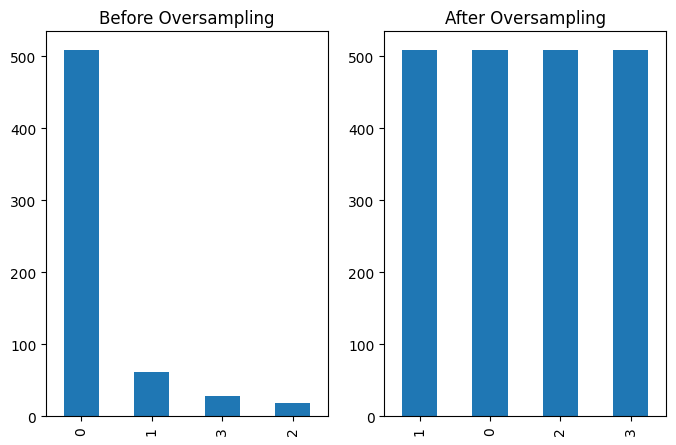

In [ ]:
# @title
# 클래스 불균형 해결
train = pd.concat([X_train, y_train, greeks],axis=1)

# oversampling
from imblearn.over_sampling import SMOTE

# greeks 테이블의 'Alpha' feature 기준
X_over1, y_over1 = SMOTE(random_state=42).fit_resample(train, greeks.Alpha)

# 오버샘플링 전후 Output특성 클래스 비교 (각각 다른 코드 블럭에서 실행)
plt.figure(figsize=(8,5))
plt.subplot(1, 2, 1)
plt.title("Before Oversampling")
greeks['Alpha'].value_counts().plot(kind = 'bar')
plt.subplot(1, 2, 2)
plt.title("After Oversampling")
y_over1.value_counts().plot(kind = 'bar')
plt.show()

In [ ]:
# @title
print(f'오버샘플링 전 shape 체크: ', greeks.Alpha.shape)
print(f'오버샘플링 후 shape 체크: ', y_over1.shape)

오버샘플링 전 shape 체크:  (617,)
오버샘플링 후 shape 체크:  (2036,)


In [ ]:
# @title
ov_train = pd.concat([X_over1, y_over1],axis=1)
ov_train

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta,Epsilon,Alpha
0,-0.572153,-0.170975,-0.261669,-0.237889,-0.189295,-1.900558,-0.083417,-0.173502,-0.038354,-0.405383,0.339209,-0.302886,0.589077,-0.052080,-0.141323,-0.187958,-0.477737,-1.297242,-0.471172,-0.482062,-0.184071,-2.395430,-1.340889,-0.151929,0.617755,0.847190,-0.334913,-0.206823,-0.733141,-0.671125,-0.371319,0.409165,0.388996,-0.122533,-0.176847,-0.287078,-0.523902,-0.166640,0.348860,1.000000,-1.023528,-0.387976,-0.167462,-0.350839,0.051544,-0.112922,-2.226608,0.162497,-0.035806,-0.251857,-0.940094,-0.410260,-0.655511,-0.948991,0.531241,-0.814910,1,1,2,4,3,0,1
1,-0.709105,-1.097801,-0.261669,-0.028701,-0.189295,-0.750457,-0.083417,0.678919,-0.104787,0.048541,-0.575174,-0.410427,-0.899462,-0.154167,-0.141323,-0.294715,-0.776607,-0.768742,-0.380234,0.055912,-0.150931,1.336593,-0.498868,-0.049436,0.704580,0.928108,-0.703485,-0.206823,-0.031113,-0.423071,-0.675043,1.389567,-0.199154,-0.122533,-0.506390,-0.669271,-1.072690,-0.346584,-0.163632,0.000000,1.088176,-0.141038,-0.043236,-0.327962,-0.102520,-0.311056,0.084542,-0.458271,-0.060566,0.112170,-1.145070,-0.410260,0.687893,-0.238862,-0.509218,1.304748,0,0,2,6,1,0,0
2,-0.015212,-0.377169,-0.261669,-0.094845,-0.189295,0.465662,-0.083417,0.519453,-0.104787,-0.071089,1.456789,-0.556635,1.307838,-0.097236,-0.141323,-0.280350,-0.734334,-0.083354,-0.432487,0.378696,-0.184071,-0.149169,0.141845,-0.695142,-0.389911,0.929115,-0.253473,-0.206823,-1.386753,-0.312920,-1.039165,0.209516,-0.056781,-0.122533,0.578520,-0.203224,2.470916,-0.132589,0.039058,1.000000,1.088176,-0.387976,-0.163455,0.924601,0.028054,-0.173811,0.517060,0.198341,-0.051023,0.595806,1.637944,-0.299210,-0.051850,-0.351743,-0.424754,-0.807481,0,0,2,6,1,0,0
3,-0.480851,0.138196,0.012347,0.547477,-0.189295,-0.729610,-0.083417,0.112088,-0.104787,-0.391109,0.644004,0.032419,-0.939432,-0.073537,-0.141323,-0.389772,0.108090,-0.040595,-0.655850,-0.105480,-0.001802,-0.377933,0.243409,-1.228106,-0.385077,-0.181774,-0.646618,-0.206823,-0.660517,-0.083097,-0.822960,-0.250951,0.094615,-0.122533,1.415032,-0.272247,0.363960,7.804389,0.167593,1.000000,-1.002074,-0.387976,-0.096939,-0.073095,0.014748,0.058201,1.617160,0.060037,-0.060566,-0.106246,-0.219883,-0.342195,-0.650833,0.858232,1.101332,-0.811468,0,0,2,6,1,0,0
4,-0.206946,0.100517,-0.261669,-0.356885,-0.189295,-0.628845,-0.013229,-1.649292,1.445139,0.125327,0.745602,0.507084,0.556808,0.641647,-0.141323,0.032566,-0.580232,-0.341605,1.423044,-0.347569,-0.184071,-0.174795,-0.300995,-1.033369,0.495398,1.082256,-0.635372,-0.206823,-1.410960,-0.570275,-1.486749,-0.043656,-0.072838,-0.122533,-0.957029,-0.277951,0.207163,-0.183137,-0.076294,1.000000,1.088176,-0.191049,-0.046107,-0.255804,-0.041041,0.520331,1.212850,0.236981,0.896815,-0.231056,-0.432313,0.099920,-0.318309,1.409422,-0.395228,-0.817211,1,2,1,3,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2031,0.441093,1.361722,-0.068010,-0.288620,-0.189295,-0.226935,-0.050603,-0.396710,-0.006105,-0.172851,0.346421,-0.478636,-0.449478,-0.126132,-0.141323,-0.355640,-0.986859,0.630844,-0.564933,0.822553,-0.033244,-0.811638,-0.416774,0.444735,-0.114889,-1.373876,-0.861842,0.426577,-0.041473,-0.138332,0.365956,1.599704,1.056136,-0.122533,-0.210831,0.208962,-0.543211,0.053623,0.658647,1.000000,-0.483668,-0.387976,-0.144720,-0.265956,0.104546,-0.269265,-1.117156,0.370383,-0.054424,0.113668,-1.105992,-0.410260,-0.315057,0.959637,-0.230834,-0.818536,1,3,2,0,1,0,3
2032,2.756019,1.087772,3.534400,-0.205371,-0.189295,-0.072977,-0.083417,1.115689,-0.075418,-0.225794,1.411946,0.367535,-0.448547,0.510410,0.518906,2.838775,-0.647192,2.387626

In [ ]:
# @title
# Class & Alpha 제외
X_train = ov_train.iloc[:,:-7]
X_train

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,-0.572153,-0.170975,-0.261669,-0.237889,-0.189295,-1.900558,-0.083417,-0.173502,-0.038354,-0.405383,0.339209,-0.302886,0.589077,-0.052080,-0.141323,-0.187958,-0.477737,-1.297242,-0.471172,-0.482062,-0.184071,-2.395430,-1.340889,-0.151929,0.617755,0.847190,-0.334913,-0.206823,-0.733141,-0.671125,-0.371319,0.409165,0.388996,-0.122533,-0.176847,-0.287078,-0.523902,-0.166640,0.348860,1.000000,-1.023528,-0.387976,-0.167462,-0.350839,0.051544,-0.112922,-2.226608,0.162497,-0.035806,-0.251857,-0.940094,-0.410260,-0.655511,-0.948991,0.531241,-0.814910
1,-0.709105,-1.097801,-0.261669,-0.028701,-0.189295,-0.750457,-0.083417,0.678919,-0.104787,0.048541,-0.575174,-0.410427,-0.899462,-0.154167,-0.141323,-0.294715,-0.776607,-0.768742,-0.380234,0.055912,-0.150931,1.336593,-0.498868,-0.049436,0.704580,0.928108,-0.703485,-0.206823,-0.031113,-0.423071,-0.675043,1.389567,-0.199154,-0.122533,-0.506390,-0.669271,-1.072690,-0.346584,-0.163632,0.000000,1.088176,-0.141038,-0.043236,-0.327962,-0.102520,-0.311056,0.084542,-0.458271,-0.060566,0.112170,-1.145070,-0.410260,0.687893,-0.238862,-0.509218,1.304748
2,-0.015212,-0.377169,-0.261669,-0.094845,-0.189295,0.465662,-0.083417,0.519453,-0.104787,-0.071089,1.456789,-0.556635,1.307838,-0.097236,-0.141323,-0.280350,-0.734334,-0.083354,-0.432487,0.378696,-0.184071,-0.149169,0.141845,-0.695142,-0.389911,0.929115,-0.253473,-0.206823,-1.386753,-0.312920,-1.039165,0.209516,-0.056781,-0.122533,0.578520,-0.203224,2.470916,-0.132589,0.039058,1.000000,1.088176,-0.387976,-0.163455,0.924601,0.028054,-0.173811,0.517060,0.198341,-0.051023,0.595806,1.637944,-0.299210,-0.051850,-0.351743,-0.424754,-0.807481
3,-0.480851,0.138196,0.012347,0.547477,-0.189295,-0.729610,-0.083417,0.112088,-0.104787,-0.391109,0.644004,0.032419,-0.939432,-0.073537,-0.141323,-0.389772,0.108090,-0.040595,-0.655850,-0.105480,-0.001802,-0.377933,0.243409,-1.228106,-0.385077,-0.181774,-0.646618,-0.206823,-0.660517,-0.083097,-0.822960,-0.250951,0.094615,-0.122533,1.415032,-0.272247,0.363960,7.804389,0.167593,1.000000,-1.002074,-0.387976,-0.096939,-0.073095,0.014748,0.058201,1.617160,0.060037,-0.060566,-0.106246,-0.219883,-0.342195,-0.650833,0.858232,1.101332,-0.811468
4,-0.206946,0.100517,-0.261669,-0.356885,-0.189295,-0.628845,-0.013229,-1.649292,1.445139,0.125327,0.745602,0.507084,0.556808,0.641647,-0.141323,0.032566,-0.580232,-0.341605,1.423044,-0.347569,-0.184071,-0.174795,-0.300995,-1.033369,0.495398,1.082256,-0.635372,-0.206823,-1.410960,-0.570275,-1.486749,-0.043656,-0.072838,-0.122533,-0.957029,-0.277951,0.207163,-0.183137,-0.076294,1.000000,1.088176,-0.191049,-0.046107,-0.255804,-0.041041,0.520331,1.212850,0.236981,0.896815,-0.231056,-0.432313,0.099920,-0.318309,1.409422,-0.395228,-0.817211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2031,0.441093,1.361722,-0.068010,-0.288620,-0.189295,-0.226935,-0.050603,-0.396710,-0.006105,-0.172851,0.346421,-0.478636,-0.449478,-0.126132,-0.141323,-0.355640,-0.986859,0.630844,-0.564933,0.822553,-0.033244,-0.811638,-0.416774,0.444735,-0.114889,-1.373876,-0.861842,0.426577,-0.041473,-0.138332,0.365956,1.599704,1.056136,-0.122533,-0.210831,0.208962,-0.543211,0.053623,0.658647,1.000000,-0.483668,-0.387976,-0.144720,-0.265956,0.104546,-0.269265,-1.117156,0.370383,-0.054424,0.113668,-1.105992,-0.410260,-0.315057,0.959637,-0.230834,-0.818536
2032,2.756019,1.087772,3.534400,-0.205371,-0.189295,-0.072977,-0.083417,1.115689,-0.075418,-0.225794,1.411946,0.367535,-0.448547,0.510410,0.518906,2.838775,-0.647192,2.387626,-0.368086,3.567438,-0.147649,-0.910008,-0.139851,-1.714149,-0.081785,-0.417932,-0.285020,-0.206823,-1.426621,0.601302,-1.044809,0.817394,-0.199154,-0.0978

In [ ]:
# @title
greeks = ov_train.iloc[:,-6:-1]
greeks

,Alpha,Beta,Gamma,Delta,Epsilon
0,1,2,4,3,0
1,0,2,6,1,0
2,0,2,6,1,0
3,0,2,6,1,0
4,2,1,3,1,0
...,...,...,...,...,...
2031,3,2,0,1,0
2032,3,2,1,2,0
2033,3,1,1,1,0
2034,3,0,0,0,0


In [ ]:
# @title
y_train = ov_train.iloc[:,-7:-6]
y_train

,Class
0,1
1,0
2,0
3,0
4,1
...,...
2031,1
2032,1
2033,1
2034,1


In [ ]:
# @title
Train = pd.concat([X_train, y_train],axis=1)
Train

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,-0.572153,-0.170975,-0.261669,-0.237889,-0.189295,-1.900558,-0.083417,-0.173502,-0.038354,-0.405383,0.339209,-0.302886,0.589077,-0.052080,-0.141323,-0.187958,-0.477737,-1.297242,-0.471172,-0.482062,-0.184071,-2.395430,-1.340889,-0.151929,0.617755,0.847190,-0.334913,-0.206823,-0.733141,-0.671125,-0.371319,0.409165,0.388996,-0.122533,-0.176847,-0.287078,-0.523902,-0.166640,0.348860,1.000000,-1.023528,-0.387976,-0.167462,-0.350839,0.051544,-0.112922,-2.226608,0.162497,-0.035806,-0.251857,-0.940094,-0.410260,-0.655511,-0.948991,0.531241,-0.814910,1
1,-0.709105,-1.097801,-0.261669,-0.028701,-0.189295,-0.750457,-0.083417,0.678919,-0.104787,0.048541,-0.575174,-0.410427,-0.899462,-0.154167,-0.141323,-0.294715,-0.776607,-0.768742,-0.380234,0.055912,-0.150931,1.336593,-0.498868,-0.049436,0.704580,0.928108,-0.703485,-0.206823,-0.031113,-0.423071,-0.675043,1.389567,-0.199154,-0.122533,-0.506390,-0.669271,-1.072690,-0.346584,-0.163632,0.000000,1.088176,-0.141038,-0.043236,-0.327962,-0.102520,-0.311056,0.084542,-0.458271,-0.060566,0.112170,-1.145070,-0.410260,0.687893,-0.238862,-0.509218,1.304748,0
2,-0.015212,-0.377169,-0.261669,-0.094845,-0.189295,0.465662,-0.083417,0.519453,-0.104787,-0.071089,1.456789,-0.556635,1.307838,-0.097236,-0.141323,-0.280350,-0.734334,-0.083354,-0.432487,0.378696,-0.184071,-0.149169,0.141845,-0.695142,-0.389911,0.929115,-0.253473,-0.206823,-1.386753,-0.312920,-1.039165,0.209516,-0.056781,-0.122533,0.578520,-0.203224,2.470916,-0.132589,0.039058,1.000000,1.088176,-0.387976,-0.163455,0.924601,0.028054,-0.173811,0.517060,0.198341,-0.051023,0.595806,1.637944,-0.299210,-0.051850,-0.351743,-0.424754,-0.807481,0
3,-0.480851,0.138196,0.012347,0.547477,-0.189295,-0.729610,-0.083417,0.112088,-0.104787,-0.391109,0.644004,0.032419,-0.939432,-0.073537,-0.141323,-0.389772,0.108090,-0.040595,-0.655850,-0.105480,-0.001802,-0.377933,0.243409,-1.228106,-0.385077,-0.181774,-0.646618,-0.206823,-0.660517,-0.083097,-0.822960,-0.250951,0.094615,-0.122533,1.415032,-0.272247,0.363960,7.804389,0.167593,1.000000,-1.002074,-0.387976,-0.096939,-0.073095,0.014748,0.058201,1.617160,0.060037,-0.060566,-0.106246,-0.219883,-0.342195,-0.650833,0.858232,1.101332,-0.811468,0
4,-0.206946,0.100517,-0.261669,-0.356885,-0.189295,-0.628845,-0.013229,-1.649292,1.445139,0.125327,0.745602,0.507084,0.556808,0.641647,-0.141323,0.032566,-0.580232,-0.341605,1.423044,-0.347569,-0.184071,-0.174795,-0.300995,-1.033369,0.495398,1.082256,-0.635372,-0.206823,-1.410960,-0.570275,-1.486749,-0.043656,-0.072838,-0.122533,-0.957029,-0.277951,0.207163,-0.183137,-0.076294,1.000000,1.088176,-0.191049,-0.046107,-0.255804,-0.041041,0.520331,1.212850,0.236981,0.896815,-0.231056,-0.432313,0.099920,-0.318309,1.409422,-0.395228,-0.817211,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2031,0.441093,1.361722,-0.068010,-0.288620,-0.189295,-0.226935,-0.050603,-0.396710,-0.006105,-0.172851,0.346421,-0.478636,-0.449478,-0.126132,-0.141323,-0.355640,-0.986859,0.630844,-0.564933,0.822553,-0.033244,-0.811638,-0.416774,0.444735,-0.114889,-1.373876,-0.861842,0.426577,-0.041473,-0.138332,0.365956,1.599704,1.056136,-0.122533,-0.210831,0.208962,-0.543211,0.053623,0.658647,1.000000,-0.483668,-0.387976,-0.144720,-0.265956,0.104546,-0.269265,-1.117156,0.370383,-0.054424,0.113668,-1.105992,-0.410260,-0.315057,0.959637,-0.230834,-0.818536,1
2032,2.756019,1.087772,3.534400,-0.205371,-0.189295,-0.072977,-0.083417,1.115689,-0.075418,-0.225794,1.411946,0.367535,-0.448547,0.510410,0.518906,2.838775,-0.647192,2.387626,-0.368086,3.567438,-0.147649,-0.910008,-0.139851,-1.714149,-0.081785,-0.417932,-0.285020,-0.206823,-1.426621,0.601302,-1.044809,0.81

In [ ]:
# @title
print(X_train.shape, y_train.shape, greeks.shape)

(2036, 56) (2036, 1) (2036, 5)


# Automl flaml 시작

In [ ]:
# Automl을 위해 values로 바꿈
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values

## LGBM

In [ ]:
auto_model = AutoML()
settings = {
    "metric": 'log_loss', # primary metrics for regression can be chosen from: ['mae','mse','r2']
    "estimator_list": ['lgbm'], # list of ML learners; we tune xgboost in this example
    "task": 'classification', # task type
    "log_file_name": 'carbon_monoxide_predictor.log',
    "time_budget": 100# flaml log file
}
auto_model.fit(X_train=X_train, y_train=y_train, **settings) # X_train, y_train

[flaml.automl.logger: 07-27 07:00:06] {1693} INFO - task = classification
[flaml.automl.logger: 07-27 07:00:06] {1700} INFO - Data split method: stratified
[flaml.automl.logger: 07-27 07:00:06] {1703} INFO - Evaluation method: cv
[flaml.automl.logger: 07-27 07:00:06] {1801} INFO - Minimizing error metric: log_loss
[flaml.automl.logger: 07-27 07:00:06] {1911} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl.logger: 07-27 07:00:06] {2221} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 07-27 07:00:07] {2347} INFO - Estimated sufficient time budget=10942s. Estimated necessary time budget=11s.
[flaml.automl.logger: 07-27 07:00:07] {2394} INFO -  at 1.1s,	estimator lgbm's best error=0.4293,	best estimator lgbm's best error=0.4293
[flaml.automl.logger: 07-27 07:00:07] {2221} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 07-27 07:00:08] {2394} INFO -  at 1.8s,	estimator lgbm's best error=0.4293,	best estimator lgbm's best error=0.4293
[flaml.aut

In [ ]:
print('Best estimator:', auto_model.best_estimator)
print('Best hyperparmeter config:', auto_model.best_config)
print('Training duration of best run: {0:.4g} s'.format(auto_model.best_config_train_time))
print(auto_model.model.estimator)

Best estimator: lgbm
Best hyperparmeter config: {'n_estimators': 94, 'num_leaves': 9, 'min_child_samples': 4, 'learning_rate': 0.20204929944793612, 'log_max_bin': 10, 'colsample_bytree': 0.8302082011667893, 'reg_alpha': 0.003148211294343311, 'reg_lambda': 0.003165384302202214}
Training duration of best run: 0.3767 s
LGBMClassifier(colsample_bytree=0.8302082011667893,
               learning_rate=0.20204929944793612, max_bin=1023,
               min_child_samples=4, n_estimators=94, num_leaves=9,
               reg_alpha=0.003148211294343311, reg_lambda=0.003165384302202214,
               verbose=-1)


## xgboost

In [ ]:
auto_model = AutoML()
settings = {
    "metric": 'log_loss', # primary metrics for regression can be chosen from: ['mae','mse','r2']
    "estimator_list": ['xgboost'], # list of ML learners; we tune xgboost in this example
    "task": 'classification', # task type
    "log_file_name": 'carbon_monoxide_predictor.log',
    "time_budget": 60# flaml log file
}
auto_model.fit(X_train=X_train, y_train=y_train, **settings) # X_train, y_train

print('Best estimator:', auto_model.best_estimator)
print('Best hyperparmeter config:', auto_model.best_config)
print('Training duration of best run: {0:.4g} s'.format(auto_model.best_config_train_time))

[flaml.automl.logger: 07-27 07:12:33] {1693} INFO - task = classification
[flaml.automl.logger: 07-27 07:12:33] {1700} INFO - Data split method: stratified
[flaml.automl.logger: 07-27 07:12:33] {1703} INFO - Evaluation method: cv
[flaml.automl.logger: 07-27 07:12:33] {1801} INFO - Minimizing error metric: log_loss
[flaml.automl.logger: 07-27 07:12:33] {1911} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 07-27 07:12:33] {2221} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 07-27 07:12:33] {2347} INFO - Estimated sufficient time budget=1253s. Estimated necessary time budget=1s.
[flaml.automl.logger: 07-27 07:12:33] {2394} INFO -  at 0.1s,	estimator xgboost's best error=0.5133,	best estimator xgboost's best error=0.5133
[flaml.automl.logger: 07-27 07:12:33] {2221} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 07-27 07:12:33] {2394} INFO -  at 0.3s,	estimator xgboost's best error=0.5133,	best estimator xgboost's best erro

In [ ]:
auto_model.model.estimator

XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=0.1853522495956892, colsample_bynode=None,
              colsample_bytree=0.9140382943863947, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.4062723134434622, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=12,
              min_child_weight=0.6026317601413242, missing=nan,
              monotone_constraints=None, n_estimators=144, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

## Catboost

In [ ]:
auto_model = AutoML()
settings = {
    "metric": 'log_loss', # primary metrics for regression can be chosen from: ['mae','mse','r2']
    "estimator_list": ['catboost'], # list of ML learners; we tune xgboost in this example
    "task": 'classification', # task type
    "log_file_name": 'carbon_monoxide_predictor.log',
    "time_budget": 60# flaml log file
}
auto_model.fit(X_train=X_train, y_train=y_train, **settings) # X_train, y_train

print('Best estimator:', auto_model.best_estimator)
print('Best hyperparmeter config:', auto_model.best_config)
print('Training duration of best run: {0:.4g} s'.format(auto_model.best_config_train_time))

[flaml.automl.logger: 07-27 07:14:10] {1693} INFO - task = classification
[flaml.automl.logger: 07-27 07:14:10] {1700} INFO - Data split method: stratified
[flaml.automl.logger: 07-27 07:14:10] {1703} INFO - Evaluation method: cv
[flaml.automl.logger: 07-27 07:14:10] {1801} INFO - Minimizing error metric: log_loss
[flaml.automl.logger: 07-27 07:14:10] {1911} INFO - List of ML learners in AutoML Run: ['catboost']
[flaml.automl.logger: 07-27 07:14:10] {2221} INFO - iteration 0, current learner catboost
[flaml.automl.logger: 07-27 07:14:15] {2347} INFO - Estimated sufficient time budget=51236s. Estimated necessary time budget=51s.
[flaml.automl.logger: 07-27 07:14:15] {2394} INFO -  at 5.1s,	estimator catboost's best error=0.0575,	best estimator catboost's best error=0.0575
[flaml.automl.logger: 07-27 07:14:15] {2221} INFO - iteration 1, current learner catboost
[flaml.automl.logger: 07-27 07:14:25] {2394} INFO -  at 14.8s,	estimator catboost's best error=0.0567,	best estimator catboost's

In [ ]:
auto_model.model.estimator

## RandomForest

In [ ]:
auto_model = AutoML()
settings = {
    "metric": 'log_loss', # primary metrics for regression can be chosen from: ['mae','mse','r2']
    "estimator_list": ['rf'], # list of ML learners; we tune xgboost in this example
    "task": 'classification', # task type
    "log_file_name": 'carbon_monoxide_predictor.log',
    "time_budget": 60# flaml log file
}
auto_model.fit(X_train=X_train, y_train=y_train, **settings) # X_train, y_train

print('Best estimator:', auto_model.best_estimator)
print('Best hyperparmeter config:', auto_model.best_config)
print('Training duration of best run: {0:.4g} s'.format(auto_model.best_config_train_time))

[flaml.automl.logger: 07-27 07:09:11] {1693} INFO - task = classification
[flaml.automl.logger: 07-27 07:09:11] {1700} INFO - Data split method: stratified
[flaml.automl.logger: 07-27 07:09:11] {1703} INFO - Evaluation method: cv
[flaml.automl.logger: 07-27 07:09:11] {1801} INFO - Minimizing error metric: log_loss
[flaml.automl.logger: 07-27 07:09:11] {1911} INFO - List of ML learners in AutoML Run: ['rf']
[flaml.automl.logger: 07-27 07:09:11] {2221} INFO - iteration 0, current learner rf
[flaml.automl.logger: 07-27 07:09:12] {2347} INFO - Estimated sufficient time budget=2408s. Estimated necessary time budget=2s.
[flaml.automl.logger: 07-27 07:09:12] {2394} INFO -  at 0.3s,	estimator rf's best error=0.3387,	best estimator rf's best error=0.3387
[flaml.automl.logger: 07-27 07:09:12] {2221} INFO - iteration 1, current learner rf
[flaml.automl.logger: 07-27 07:09:12] {2394} INFO -  at 0.5s,	estimator rf's best error=0.2755,	best estimator rf's best error=0.2755
[flaml.automl.logger: 07-2

In [ ]:
print(auto_model.model.estimator)

RandomForestClassifier(criterion='entropy', max_features=0.7720255259265024,
                       max_leaf_nodes=114, n_estimators=59, n_jobs=-1,
                       random_state=12032022)
